# Dynamic Programming

Using dynamic programming we can solve the RL problem when all environment dynamics are known and we have a finite state set.

Any environment that our agent can explore needs to be described using a subclass of `Environment`. This allows us to implement a single DP algorithm once for all problems. We can then solve the individual problems by describing them using the methods from `Environment`.

In [1]:
class Environment:
    def get_states(self):
        """
        Return the set of possible states
        """
        pass
    
    def get_possible_actions(self, state):
        """
        Returns the actions that can be taken from the given state
        """
        pass
    
    def get_state_actions(self, state, action):
        """
        Return a list of (probability, new_state, reward) tuples for the
        given state and action
        """
        pass

`DPAgent` can find a perfect policy given an `Environment`. It works using value iteration. Initially, a random policy is generated. After that, each time `agent.learn()` is executed, we perform:

* policy evaluation: The value for each state is updated, by using the values of neighbouring states
* policy improvement: For each state we choose all actions that maximize the expected value

In [6]:
from random import sample
from operator import itemgetter

class DPAgent:
    def __init__(self, env, discount_factor=1):
        self.env = env
        self.discount_factor = discount_factor
        
        states = self.states = env.get_states()
        self.values = { state: 0 for state in states }
        self.policy = { state: self._random_action_init(state) for state in states }
    
    def _random_action_init(self, state):
        possible_actions = self.env.get_possible_actions(state)
        
        if len(possible_actions) == 0:
            return set()
        else:
            return set(sample(possible_actions, 1))
        
    def learn(self, evaluate=1):
        for _ in range(evaluate):
            self._evaluate_policy()
            
        self._improve_policy()
        
    def _evaluate_policy(self):
        values = self.values.copy()
        
        for state in self.states:
            value = self.values[state]
            actions = self.policy[state]
            change = 0.
            
            for action in actions:
                for prob, new_state, reward in self.env.get_state_actions(state, action):
                    next_value = self.values[new_state]
                    change += prob * (reward + self.discount_factor * next_value)
            
            values[state] = change / len(actions)

        self.values = values
    
    def _improve_policy(self):
        for state in self.states:
            action = self.policy[state]
            possible_actions = {}

            for possible_action in self.env.get_possible_actions(state):
                action_value = 0
                
                for prob, new_state, reward in self.env.get_state_actions(state, possible_action):
                    value = self.values[new_state]
                    action_value += prob * (reward + self.discount_factor * value)
                
                possible_actions[possible_action] = action_value
            
            max_value = max(possible_actions.values())            
            self.policy[state] = set([action for action, value in possible_actions.items() if value == max_value])

## GridWorld

GridWorld is on of the standard examples for dynamic programming. Our agent can move in a 2d matrix. The rewards are defined in a matrix of the same size. There environment is totally deterministic.

In [7]:
from itertools import product
import numpy as np

class GridWorld(Environment):
    def __init__(self, reward_matrix):
        self.reward_matrix = reward_matrix
        
        n, m = reward_matrix.shape
        self.states = list(product(range(n), range(m)))
        
        self.max_down = n - 1
        self.max_right = m - 1
        
        self._init_actions()
        
    def _init_actions(self):
        self.UP = "U"
        self.DOWN = "D"
        self.LEFT = "L"
        self.RIGHT = "R"
        
        self.actions = [self.UP, self.DOWN, self.LEFT, self.RIGHT]
        
    def get_states(self):
        return self.states
    
    def get_possible_actions(self, state):
        i, j = state
        
        actions = []
        
        if i > 0:
            actions.append(self.UP)
            
        if i < self.max_down:
            actions.append(self.DOWN)
        
        if j > 0:
            actions.append(self.LEFT)
        
        if j < self.max_right:
            actions.append(self.RIGHT)
            
        return actions
    
    def get_state_actions(self, state, action):
        reward = self.reward_matrix[state]
        new_state = self._get_next_state(state, action)
        
        return [(1, new_state, reward)]
    
    def _get_next_state(self, state, action):
        i, j = state        
        
        if action == self.UP:
            i -= 1
            
        if action == self.DOWN:
            i += 1
            
        if action == self.LEFT:
            j -= 1
            
        if action == self.RIGHT:
            j += 1
            
        i = max(0, min(i, self.max_down))
        j = max(0, min(j, self.max_right))
        
        return i, j

Some helper functions for visualizing the policy/values/rewards of GridWorld.

In [19]:
def draw_policy(agent, n, m):
    lookup = {
        "U": u"↑",
        "D": u"↓",
        "L": u"←",
        "R": u"→"
    }
    
    vals = sorted(agent.policy.items())
    actions = ["".join([lookup[act] for act in val]) for _, val in vals]
    
    print "Policy"
    draw_matrix(np.array(actions).reshape((n, m)))
    print

def draw_values(agent, n, m):
    vals = sorted(agent.values.items())
    vals = ["%.2f" % val for _, val in vals]
    
    print "Values"
    draw_matrix(np.array(vals).reshape((n, m)))
    print
    
from math import ceil, floor

def lrjust(s, size):
    missing = size - len(s)
    
    if missing > 0:
        left = int(ceil(missing / 2.))
        right = int(floor(missing / 2.))
        s = " " * left + s + " " * right
    
    return s

def draw_matrix(data):    
    result = ""
    rows = []
    
    for row in data:
        row_result = []
        
        for cell in row:
            row_result.append(lrjust("%s" % cell, 6))
            
        rows.append("|".join(row_result))
        
    print ("\n" + "-" * len(rows[0]) + "\n").join(rows)

### Test cases

In this simple test there's only one cell with a reward, so what we're really looking for is the shortest path to that cell.

If a cell of the policy matrix contains several action, then this means that we can take any of them.

In [9]:
R = np.array([
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]
    ])

print "Reward"
draw_matrix(R)
print

grid_world = GridWorld(R)
agent = DPAgent(grid_world, discount_factor=0.5)

for k in range(10):
    agent.learn()
    
draw_policy(agent, 3, 4)
draw_values(agent, 3, 4)

Reward
   0  |   0  |   0  |   0  
---------------------------
   0  |   0  |   1  |   0  
---------------------------
   0  |   0  |   0  |   0  

Policy
  →↓  |  →↓  |   ↓  |  ↓←  
---------------------------
   →  |   →  | →↑↓← |   ←  
---------------------------
  →↑  |  →↑  |   ↑  |  ↑←  

Values
 0.17 | 0.33 | 0.67 | 0.33 
---------------------------
 0.33 | 0.67 | 1.33 | 0.67 
---------------------------
 0.17 | 0.33 | 0.67 | 0.33 



In this new test case there's a single path without penalties to a reward.

In [10]:
R2 = np.array([
        [0, 0, 0, 0],
        [0, -1, -1, -1],
        [0, 0, 0, 0],
        [-1, -1, -1, 0],
        [1, 0, 0, 0]
    ])

print "Reward"
draw_matrix(R2)
print

grid_world = GridWorld(R2)
agent = DPAgent(grid_world, discount_factor=0.5)

for k in range(50):
    agent.learn()
    
draw_policy(agent, 5, 4)
draw_values(agent, 5, 4)

Reward
   0  |   0  |   0  |   0  
---------------------------
   0  |  -1  |  -1  |  -1  
---------------------------
   0  |   0  |   0  |   0  
---------------------------
  -1  |  -1  |  -1  |   0  
---------------------------
   1  |   0  |   0  |   0  

Policy
   ↓  |   ←  |   ←  |   ←  
---------------------------
   ↓  |   ↓  |   ↓  |   ↓  
---------------------------
   →  |   →  |   →  |   ↓  
---------------------------
   ↓  |   ↓  |   ↓  |   ↓  
---------------------------
   →  |   ←  |   ←  |   ←  

Values
 0.00 | 0.00 | 0.00 | 0.00 
---------------------------
 0.00 | -0.99| -0.99| -0.98
---------------------------
 0.01 | 0.01 | 0.02 | 0.04 
---------------------------
 -0.33| -0.67| -0.83| 0.08 
---------------------------
 1.33 | 0.67 | 0.33 | 0.17 



## Jack's car rental problem

There are two locations for car rentals. At each cars can be rented and returned. The cars don't have to be returned at the location where they were rented.

We want to move cars between the two locations, so that we maximize the number of cars that can be rented.

In [11]:
from scipy.stats import poisson
from itertools import product
from collections import defaultdict

class CarRental(Environment):
    def __init__(self, max_cars, rent_profit, move_cost, average_requests, average_returns, max_lambda):
        self.max_cars = max_cars
        self.rent_profit = rent_profit
        self.move_cost = move_cost
        self.average_requests = average_requests
        self.average_returns = average_returns
        self.max_lambda = max_lambda
        
    def get_states(self):
        car_range = range(0, self.max_cars + 1)
        return list(product(car_range, car_range))
    
    def get_possible_actions(self, state):
        """
        Returns the actions that can be taken from the given state
        """
        cars_a, cars_b = state
        return range(-cars_b, cars_a + 1)
    
    def get_state_actions(self, state, action):
        result = defaultdict(int)

        cars_a, cars_b = state        
        cars_a = max(min(cars_a - action, self.max_cars), 0)
        cars_b = max(min(cars_b + action, self.max_cars), 0)
                        
        for requested_a in range(0, self.max_lambda):
            prob1 = poisson.pmf(requested_a, self.average_requests[0])
            
            for requested_b in range(0, self.max_lambda):
                prob2 = poisson.pmf(requested_b, self.average_requests[1])
                
                rented_a = min(requested_a, cars_a)
                rented_b = min(requested_b, cars_b)
                reward = (rented_a + rented_b) * self.rent_profit
                
                for returned_a in range(0, self.max_lambda):
                    prob3 = poisson.pmf(returned_a, self.average_returns[0])
                    
                    for returned_b in range(0, self.max_lambda):
                        prob4 = poisson.pmf(returned_b, self.average_returns[1])
                        prob = prob1 * prob2 * prob3 * prob4
                        
                        if cars_a < rented_a or cars_b < rented_b:
                            print "problem"
                            print cars_a, cars_b
                            print rented_a, rented_b
                            print requested_a, requested_b, returned_a, returned_b
                            return []
                        
                        new_cars_a = min(cars_a + returned_a - rented_a, self.max_cars)
                        new_cars_b = min(cars_b + returned_b - rented_b, self.max_cars)
                        new_state = (new_cars_a, new_cars_b)
                        
                        result[(new_state, reward)] += prob
                        
        return [(prob, new_state, reward) for (new_state, reward), prob in result.items()]

In [12]:
def visualize_car_rental_policy(agent):
    policy = agent.policy
    max_n = agent.env.max_cars
    
    result = ""
    
    for i in reversed(range(max_n + 1)):
        result += " %d |" % i
        for j in range(max_n + 1):
            result += "%+4s" % str(list(policy[(i, j)])[0])
            
        result += "\n"
        
    result += " " * 4
    for j in range(max_n + 1):
        result += "-" * 4
    
    result += "\n"
    result += " " * 4
    for j in range(max_n + 1):
        result += "%+4s" % str(j)
        

    print "Car Rental Policy\n(y-axis location 1, x-axis location 2)\n"
    print result

Unfortunately, because of the poisson distributions, this problem takes pretty long to compute. Because of this, we use fewer cars than in the Sutton & Barto book.

In [13]:
env = CarRental(
    max_cars=3,
    rent_profit=10,
    move_cost=2,
    average_requests=[1, 1],
    average_returns=[0, 2],
    max_lambda=5
)

In [14]:
car_rental_agent = DPAgent(env, discount_factor=0.8)

for _ in range(5):
    car_rental_agent.learn()
    
visualize_car_rental_policy(car_rental_agent)

Car Rental Policy
(y-axis location 1, x-axis location 2)

 3 |   1   1   0   0
 2 |   1   0   0  -1
 1 |   0   0  -1  -1
 0 |   0  -1  -1  -2
    ----------------
       0   1   2   3


## Gambler's problem

A gambler can put a chosen amount of money on a bet with a winning probability of `p_win`. If the gambler wins, he gains as much money as his stake, otherwise he loses the stake.

The gambler wins the entire game if he manages to get to $100. We want to find an optimal policy to do this.

In [38]:
class GamblerProblem(Environment):
    def __init__(self, goal, p_win):
        self.goal = goal
        self.p_win = p_win
    
    def get_states(self):
        return range(self.goal + 1)
    
    def get_possible_actions(self, capital):
        return range(min(capital, self.goal - capital) + 1)
    
    def get_state_actions(self, capital, stake):
        if capital == 0:
            return [(1, 0, 0)]
        
        if capital == self.goal:
            return [(1, 0, 100)]
        
        if capital + stake == self.goal:
            possible_reward = 1
        else:
            possible_reward = 0
        
        return [
            (self.p_win, capital + stake, possible_reward),
            (1 - self.p_win, capital - stake, 0)
        ]

In [39]:
env = GamblerProblem(goal=100, p_win=0.4)

gambling_agent = DPAgent(env, discount_factor=1)

gambling_agent.learn(evaluate=10)
gambling_agent.learn(evaluate=100)
gambling_agent.learn(evaluate=500)

Policy:

In [34]:
gambling_agent.policy

{0: {0},
 1: {0, 1},
 2: {0, 2},
 3: {0, 3},
 4: {0, 4},
 5: {4},
 6: {5},
 7: {0, 7},
 8: {1},
 9: {0, 9},
 10: {3, 10},
 11: {0, 2, 11},
 12: {12},
 13: {0, 13},
 14: {0, 14},
 15: {15},
 16: {16},
 17: {8},
 18: {0, 18},
 19: {6},
 20: {20},
 21: {0, 21},
 22: {22},
 23: {2, 23},
 24: {0, 24},
 25: {0, 25},
 26: {0, 1, 26},
 27: {0, 2, 27},
 28: {3},
 29: {4},
 30: {5},
 31: {31},
 32: {7},
 33: {8},
 34: {16},
 35: {0, 10, 35},
 36: {0, 36},
 37: {13},
 38: {38},
 39: {0, 39},
 40: {0, 40},
 41: {0, 41},
 42: {8},
 43: {7},
 44: {6, 44},
 45: {0, 5, 45},
 46: {0, 4, 46},
 47: {3},
 48: {0, 48},
 49: {1},
 50: {0, 50},
 51: {0, 1},
 52: {0, 2},
 53: {0, 3},
 54: {0, 4},
 55: {5},
 56: {6},
 57: {7},
 58: {8},
 59: {41},
 60: {10},
 61: {11},
 62: {12, 38},
 63: {0, 12, 13},
 64: {14},
 65: {0, 15},
 66: {16},
 67: {0, 8},
 68: {32},
 69: {0, 6},
 70: {0, 5, 20, 30},
 71: {0, 4},
 72: {3},
 73: {0, 2},
 74: {1},
 75: {0, 25},
 76: {0, 1, 24},
 77: {0, 23},
 78: {3},
 79: {21},
 80: {

The visualisation is a bit different than the one in the Sutton & Barto book. This is because it's not totally clear how to visualize the policy. For many states, there are multiple optimal actions. In the book, the visualisation chooses one action per state.

This first visualisation only shows the action with the maximum stake:

In [16]:
%matplotlib inline

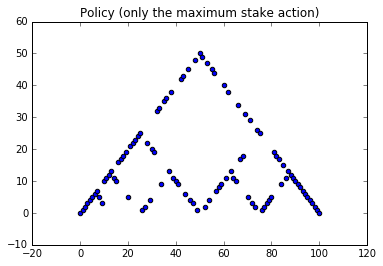

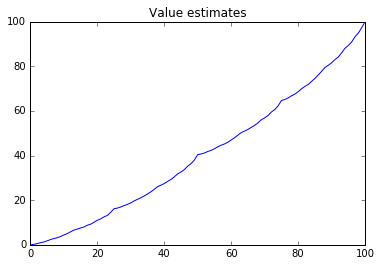

In [41]:
data = [(capital, max(opts)) for capital, opts in gambling_agent.policy.items()]
x, y = zip(*data)

import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.title("Policy (only the maximum stake action)")
plt.show()

x, y = zip(*gambling_agent.values.items())
plt.plot(x, y)
plt.title("Value estimates")
plt.show()

This visualisation shows all optimal actions:

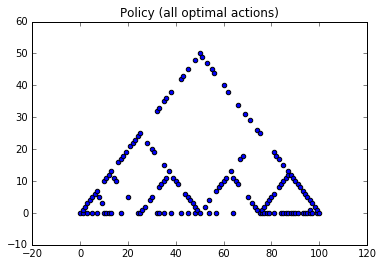

In [40]:
x = []
y = []

for a, bs in gambling_agent.policy.items():
    for b in bs:
        x.append(a)
        y.append(b)

plt.scatter(x, y)
plt.title("Policy (all optimal actions)")
plt.show()